# Введение в нейронные сети
## Урок 6. Сегментация

### Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?

In [ ]:
# !pip install opendatasets

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image

import opendatasets as od

from collections import defaultdict

In [ ]:
od.download("https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels/download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wildzes
Your Kaggle Key: ··········


100%|██████████| 9.58G/9.58G [03:21<00:00, 51.1MB/s]


In [ ]:
image_dir = '/content/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/'
mask_dir = '/content/chest-xray-masks-and-labels/data/Lung Segmentation/masks/'

In [ ]:
image_names = os.listdir(image_dir)
mask_names = os.listdir(mask_dir)

In [ ]:
def create_df(image_names, mask_names):
  result = defaultdict(list)
  for i_name in set(image_names):
    for m_name in mask_names:
      if i_name in m_name:
        result['image_paths'].append(os.path.join(image_dir, i_name))
        result['mask_paths'].append(os.path.join(mask_dir, m_name))
  return pd.DataFrame.from_dict(result)

In [ ]:
df = create_df(image_names, mask_names)
df.head()

,image_paths,mask_paths
0,/content/chest-xray-masks-and-labels/data/Lung...,/content/chest-xray-masks-and-labels/data/Lung...
1,/content/chest-xray-masks-and-labels/data/Lung...,/content/chest-xray-masks-and-labels/data/Lung...
2,/content/chest-xray-masks-and-labels/data/Lung...,/content/chest-xray-masks-and-labels/data/Lung...
3,/content/chest-xray-masks-and-labels/data/Lung...,/content/chest-xray-masks-and-labels/data/Lung...
4,/content/chest-xray-masks-and-labels/data/Lung...,/content/chest-xray-masks-and-labels/data/Lung...


In [ ]:
import cv2
def prepare_train_test(df, resize_shape = tuple(), color_mode = "rgb"):
    imgages = list()
    masks = list()

    for image_path in df.image_paths:
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            imgages.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
  
    for mask_path in df.mask_paths:
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        masks.append(resized_mask[:,:,0])

    return imgages, masks

In [ ]:
images, masks = prepare_train_test(df, resize_shape = (256,256), color_mode = "gray")

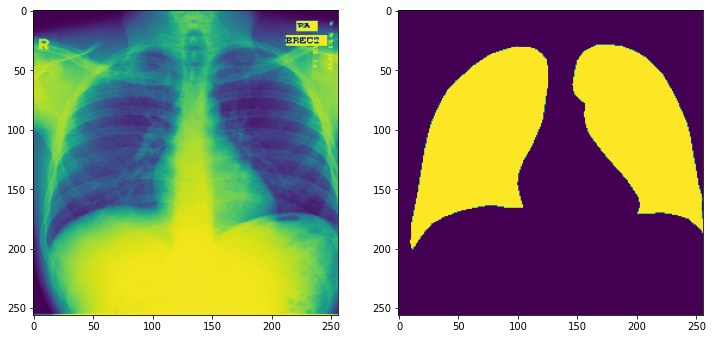

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[10])
ax[1].imshow(masks[10])

In [ ]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(images, masks, test_size = 0.2, random_state= 42)

img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size)

In [ ]:
from keras.models import Model
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
   
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [ ]:
from tensorflow.keras.optimizers import Adam

model = unet(input_size=(256,256,1))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[dice_coef])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
print(img_train.shape)
print(mask_train.shape)

(110, 256, 256)
(110, 256, 256)


In [ ]:
history = model.fit(x = img_train, 
                    y = mask_train, 
                    validation_data = (img_test, mask_test), 
                    epochs = 15, 
                    batch_size = 10,
                   )

Epoch 1/15
11/11 [==============================] - 222s 20s/step - loss: 343.3837 - dice_coef: 0.2633 - val_loss: 346.7962 - val_dice_coef: 0.3182
Epoch 2/15
11/11 [==============================] - 216s 20s/step - loss: 331.9981 - dice_coef: 0.3670 - val_loss: 342.1452 - val_dice_coef: 0.3869
Epoch 3/15
11/11 [==============================] - 213s 19s/step - loss: 328.1024 - dice_coef: 0.3822 - val_loss: 336.9340 - val_dice_coef: 0.3779
Epoch 4/15
11/11 [==============================] - 213s 19s/step - loss: 323.9717 - dice_coef: 0.4038 - val_loss: 335.2433 - val_dice_coef: 0.4216
Epoch 5/15
11/11 [==============================] - 210s 19s/step - loss: 324.3631 - dice_coef: 0.4381 - val_loss: 335.7451 - val_dice_coef: 0.4377
Epoch 6/15
11/11 [==============================] - 210s 19s/step - loss: 322.5416 - dice_coef: 0.4520 - val_loss: 334.3494 - val_dice_coef: 0.4450
Epoch 7/15
11/11 [==============================] - 207s 19s/step - loss: 320.2349 - dice_coef: 0.4708 - val_los

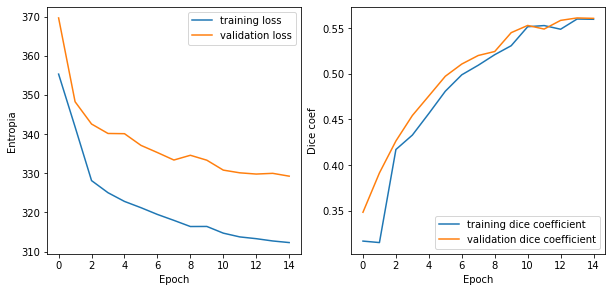

In [ ]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Entropia")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Dice coef")
    
get_metrics(history)

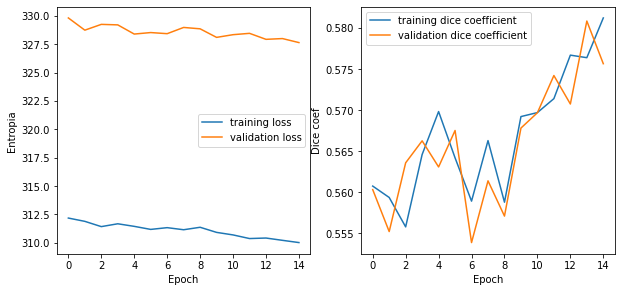

In [ ]:
get_metrics(history)

In [ ]:
n=10
pred = model.predict(img_test[n].reshape(1,img_side_size,img_side_size,1))

(-0.5, 255.5, 255.5, -0.5)

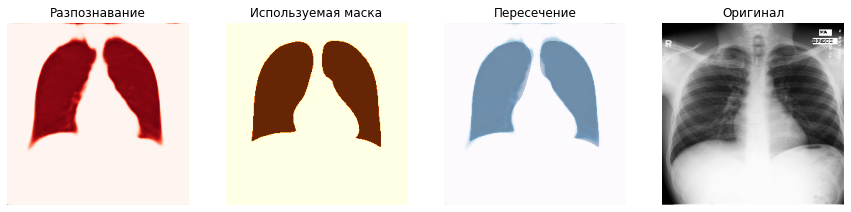

In [ ]:
fig = plt.figure(figsize = (15,10))

plt.subplot(1,4,1)
plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Reds")
plt.title("Раcпознавание")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_test[n].reshape(img_side_size, img_side_size), cmap = "YlOrBr")
plt.title("Используемая маска");
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(mask_test[n].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.4)
plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
plt.title("Пересечение")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(images[n].reshape(img_side_size, img_side_size), cmap = "gray")
plt.title("Оригинал")
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

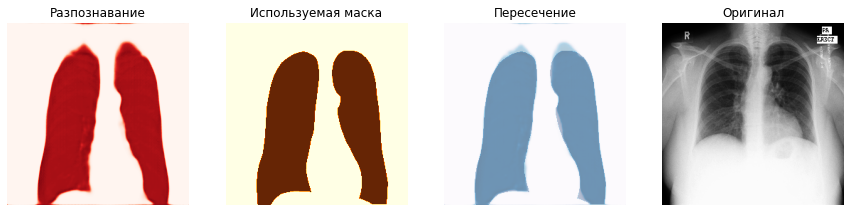

In [ ]:
n=1
pred = model.predict(img_test[n].reshape(1,img_side_size,img_side_size,1))

fig = plt.figure(figsize = (15,10))

plt.subplot(1,4,1)
plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Reds")
plt.title("Раcпознавание")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_test[n].reshape(img_side_size, img_side_size), cmap = "YlOrBr")
plt.title("Используемая маска");
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(mask_test[n].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.4)
plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
plt.title("Пересечение")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(images[n].reshape(img_side_size, img_side_size), cmap = "gray")
plt.title("Оригинал")
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

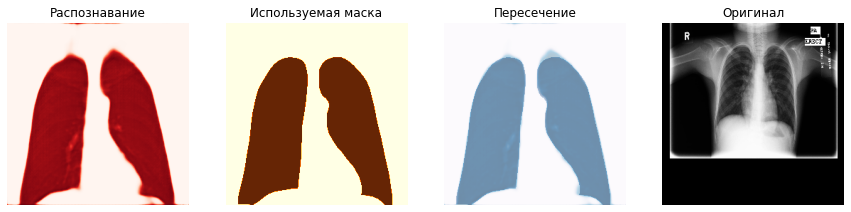

In [ ]:
n=2
pred = model.predict(img_test[n].reshape(1,img_side_size,img_side_size,1))

fig = plt.figure(figsize = (15,10))

plt.subplot(1,4,1)
plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Reds")
plt.title("Раcпознавание")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_test[n].reshape(img_side_size, img_side_size), cmap = "YlOrBr")
plt.title("Используемая маска");
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(mask_test[n].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.4)
plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
plt.title("Пересечение")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(images[n].reshape(img_side_size, img_side_size), cmap = "gray")
plt.title("Оригинал")
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

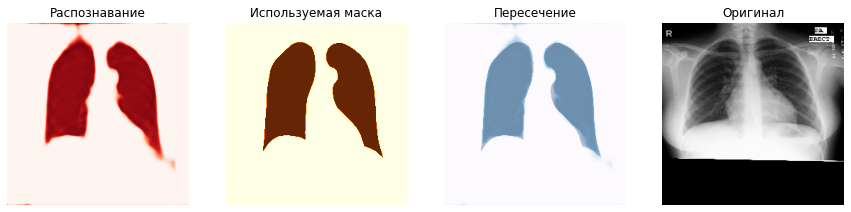

In [35]:
n=3
pred = model.predict(img_test[n].reshape(1,img_side_size,img_side_size,1))

fig = plt.figure(figsize = (15,10))

plt.subplot(1,4,1)
plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Reds")
plt.title("Раcпознавание")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_test[n].reshape(img_side_size, img_side_size), cmap = "YlOrBr")
plt.title("Используемая маска");
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(mask_test[n].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.4)
plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
plt.title("Пересечение")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(images[n].reshape(img_side_size, img_side_size), cmap = "gray")
plt.title("Оригинал")
plt.axis("off")

Выводы:
- необходимо выбирать данные, которые понятны;
- по метрике модель совсем не готова к работе, по изображениям вполне рабочая;
- потенциал у технологии чувствуется огромный, но мое участие под большим вопросом, потому что нет четкого понимания процессов работы с сетью;
- улучшать и экспериментировать больше сделанного не стал, за отсутствием понимания достигнутого результата, в связи с чем принял решение посвятить немного времени теории.

### Сделайте свою реализацию U-Net на TensorFlow

Ответ: на текущий момент - недостижимая мечта